<a href="https://colab.research.google.com/github/d4vidi4n/EL7037/blob/main/EL7037(CE)_Tarea_1_(GP)_Problema2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> EL7037 </h1>
<h2 align="center"> Tarea 1: Programación Genética </h2>
<h3 align="center"> Problema 2/2 - Proyección de datos </h3>
***

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
# drive.mount('/content/drive/MyDrive/docs phd/2025-2/Computación Evolutiva/EL7037(2025_2)_T1_GP/GPalta/Code')
os.chdir('/content/drive/MyDrive/docs phd/2025-2/Computación Evolutiva/EL7037(2025_2)_T1_GP/GPalta/Code')

In [3]:
!pip install pydotplus
!pip install jpype1

In [4]:
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import pydotplus
import jpype
import os
from utilsGPalta import *
from tqdm import tqdm
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [5]:
libGPjar = 'GPaltav2.jar'
arg = '-Djava.class.path=%s'%os.path.join(os.getcwd(),libGPjar)
jvmPath = jpype.getDefaultJVMPath()
jpype.startJVM(jvmPath, arg)
GP = jpype.JPackage("gpalta")

In [6]:
%cd "/content/drive/MyDrive/docs phd/2025-2/Computación Evolutiva/EL7037(2025_2)_T1_GP/GPalta/Code"
!python setup.py build_ext --inplace

/content/drive/MyDrive/docs phd/2025-2/Computación Evolutiva/EL7037(2025_2)_T1_GP/GPalta/Code


### Configuración GP

In [19]:
config = GP.core.Config('Config.txt')
config.nGenerations   = 10     # numero de generaciones
config.populationSize = 10       # tamaño de la poblacion
config.maxDepth       = 6       # profundidad maxima
config.initialMinDepth= 3        # profundidad minima arboles poblacion inicial
config.initialMaxDepth= 4        # profundidad maxima arboles poblacion inicial
config.population     = 'gpalta.multitree.MultiTreePopulation' # Multiarboles
config.nClasses       = 2                                      # Dimensionalidad del espacio de salida
config.fitness        = 'gpalta.core.FitnessSammon'            # criterio de fitness
config.constLowLimit  = 0
config.constUpLimit   = 10
prob_mutation         = 0.15
prob_crossover        = 0.7
# probability of crossover = upLimitProbCrossOver - 0
# probability of mutation = upLimitProbMutation - upLimitProbCrossOver
# probability of reproduction = 1 - upLimitProbMutation
config.upLimitProbCrossOver = prob_crossover
config.upLimitProbMutation  = prob_mutation + prob_crossover

# Más parámetros de configuracion de GP están en los archivos Config.txt y Nodes.txt

##### ---- Funciones disponibles ---
#['Cos', 'Sin', 'Exponential', 'Square', 'SquareRoot', 'Divide', 'Plus', 'Minus', 'Times']
selectedFuntion = ['Cos', 'Sin', 'Exponential', 'Square', 'SquareRoot', 'Divide', 'Plus', 'Minus', 'Times']
setFuntions(selectedFuntion)

## Extracción base de datos

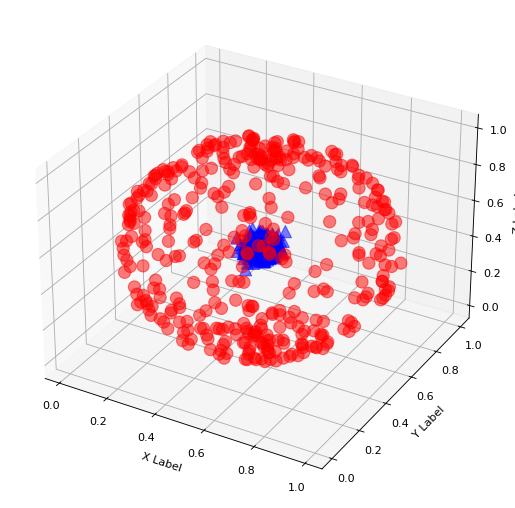

In [20]:
DB = loadmat('BASES.mat')
atom = {'data': DB['Atom'][0][0][0],'class': DB['Atom'][0][0][1]}
derm = {'data': DB['derm'][0][0][0],'class': DB['derm'][0][0][1]}

# ---------------------------- Cambia base de datos -------------------------
X = atom    # atom o derm
# ---------------------------------------------------------------------------

X['data'] = (X['data']-X['data'].min())/(X['data'].max() - X['data'].min())

X_train, X_test, y_train, y_test = train_test_split(X['data'], X['class'], test_size=0.4)
args = [('r', 'o'),('b', '^'),('g','s'),('c','v'),('m','*'),('y','p')]

fig = plt.figure(figsize=(12, 8), dpi=80)
ax = fig.add_subplot(111, projection='3d')
for i, cl in enumerate(np.unique(X['class'])):
    idx = np.where(X['class']==cl)[0]
    ax.scatter(X['data'][idx,0], X['data'][idx,1], X['data'][idx,2], c=args[i][0], marker=args[i][1], s=120, alpha=.5)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

## Main loop GP

In [21]:
def evo_execution(config):

  n_axis_proj = config.nClasses
  names   = ['fitness', 'nodes', 'EvalAll',     'tree']
  formats = [float, float,  float,  object]
  dtypes  = list(zip(names, formats))
  dtypes[1] += ((n_axis_proj,),)
  dtypes[2] += ((n_axis_proj, X['data'].shape[0]),)
  dtypes[3] += ((n_axis_proj,),)
  R = np.empty((config.populationSize, config.nGenerations),dtype=dtypes)

  evo = GP.core.Evolution(config, py2java(X_train,True),py2java(y_train), py2java(np.zeros((1,len(y_train)))),True)
  evo.eval()
  for gen in tqdm(range(config.nGenerations), desc='Generation'):
      # ------ Condicion de termino GP por tolerancia fitness ---------------
      if (evo.evoStats.bestSoFar.readFitness() >= config.stopFitness):
          print('\nObjective reached in generation %d',gen)
          break
      evo.evolve()
      evo.eval()
      for ind in range(config.populationSize):
          R['fitness'][ind,gen] = evo.population.get(ind).readFitness()
          evalTrees             = evo.getRawOutput(evo.population.get(ind), py2java(X['data'],True))
          for n_axis in range(n_axis_proj):
              R['nodes'][ind,gen,n_axis]   = evo.population.get(ind).getTree(n_axis).getSize()
              R['tree'][ind,gen,n_axis]    = evo.population.get(ind).getTree(n_axis)
              R['EvalAll'][ind,gen,n_axis] = java2py(evalTrees.getArray(n_axis))
  return R, evo

In [22]:
def n_simulations(configuration, n_sim):
  res = []
  best_trees = []

  # Cálculo de n_sim simulaciones
  for i in range(n_sim):
    res_aux = evo_execution(configuration)
    res.append(res_aux[0])
    best_trees.append(res_aux[1])

  # Extraxión de los resultados
  R1, R2, R3, R4, R5 = res
  evo1, evo2, evo3, evo4, evo5 = best_trees
  R_t = res[0][:,:,np.newaxis]

  # Concatenación de las matrices de resultados de las 5 generaciones
  for i in range(1,len(res)):
    R_t = np.concatenate((R_t, res[i][:,:,np.newaxis]), axis=2)

  for i in range(0,len(res)):
    if i == 0:
      best_tree = best_trees[i]
      best_sim = i
    elif best_tree.evoStats.bestSoFar.readFitness() > best_trees[i].evoStats.bestSoFar.readFitness():
      best_tree = best_trees[i]

  print(best_tree)

  return R_t, best_tree

In [23]:
def results_GP(results_matrix, best_tree):
  R = results_matrix
  evo = best_tree
  evalTreeBestSoFar = evo.getRawOutput(evo.evoStats.bestSoFar, py2java(X['data'],True))
  axis1 = java2py(evalTreeBestSoFar.getArray(0))
  axis2 = java2py(evalTreeBestSoFar.getArray(1))

  # Proyección 2D
  plt.figure()
  for i, cl in enumerate(np.unique(X['class'])):
      idx = np.where(X['class']==cl)[0]
      plt.scatter(axis1[idx], axis2[idx], c=args[i][0], marker=args[i][1], s=100, alpha=.7)
  plt.xlabel('Tree 1')
  plt.ylabel('Tree 2')
  plt.title('Proyección GP')
  filename = 'proy.pdf'
  filepath = os.path.join(folder, filename)
  plt.savefig(filepath, bbox_inches='tight')

  # Fitness vs Generacion
  plt.figure()
  plt.plot(np.arange(config.nGenerations), R['fitness'].max(axis=0).mean(axis=1), 'b', label='max', linewidth=2)
  plt.plot(np.arange(config.nGenerations), R['fitness'].mean(axis=0).mean(axis=1), 'k', label='mean', linewidth=2)
  plt.plot(np.arange(config.nGenerations), R['fitness'].min(axis=0).mean(axis=1), 'r', label='min', linewidth=2)
  plt.title('Fitness vs Generación')
  plt.xlabel('Generation')
  plt.ylabel('Fitness')
  plt.grid()
  plt.legend(loc='lower right')
  filename = 'fit_vs_gen.pdf'
  filepath = os.path.join(folder, filename)
  plt.savefig(filepath, bbox_inches='tight')

  # Fitness promedio  vs nodos promedios por generación
  plt.figure()
  plt.scatter(R['fitness'].mean(axis=0).mean(axis=1), R['nodes'].sum(axis=3).mean(axis=0).mean(axis=1), c=args[1][0], marker=args[1][1], s=100, alpha=.7)
  plt.ylabel('Nodos')
  plt.xlabel('Fitness')
  plt.title('Fitness vs Nodos')
  plt.grid()
  filename = 'fit_vs_nod.pdf'
  filepath = os.path.join(folder, filename)
  plt.savefig(filepath, bbox_inches='tight')

In [29]:
original_font_size = plt.rcParams['font.size']
# print(original_font_size)
plt.rcParams.update({'font.size': 16})

# 2. Aplicación de los 5 pasos preparatorios de John Koza

In [31]:
folder = 'graphs_P2/2'
os.makedirs(folder, exist_ok=True)

Generation: 100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


gpalta.core.Evolution@6b419da


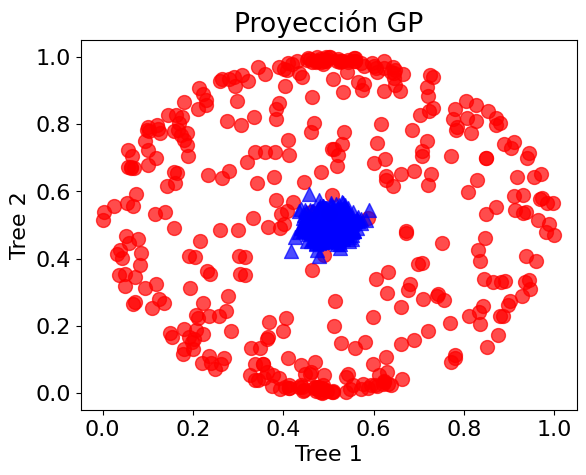

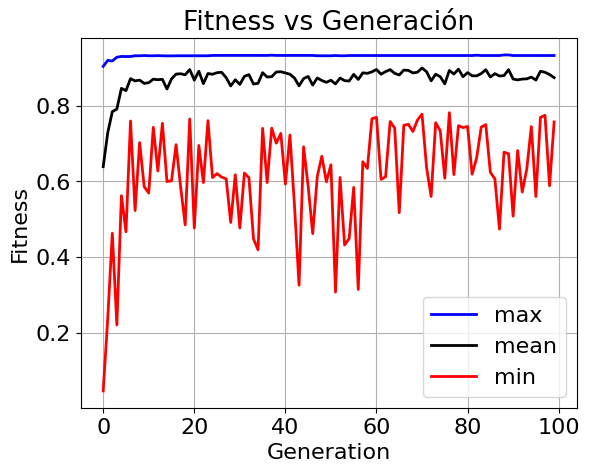

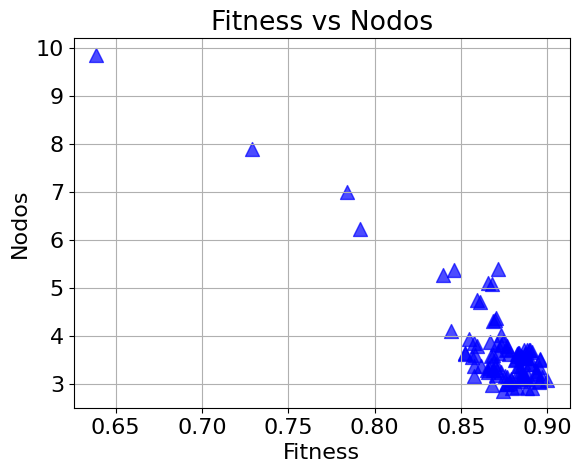

In [32]:
config.nGenerations   = 100     # numero de generaciones
config.populationSize = 20       # tamaño de la poblacion
config.maxDepth       = 3       # profundidad maxima
config.initialMinDepth= 3        # profundidad minima arboles poblacion inicial
config.initialMaxDepth= 4        # profundidad maxima arboles poblacion inicial
config.population     = 'gpalta.multitree.MultiTreePopulation' # Multiarboles
config.nClasses       = 2                                      # Dimensionalidad del espacio de salida
prob_mutation         = 0.15
prob_crossover        = 0.7
# probability of crossover = upLimitProbCrossOver - 0
# probability of mutation = upLimitProbMutation - upLimitProbCrossOver
# probability of reproduction = 1 - upLimitProbMutation
config.upLimitProbCrossOver = prob_crossover
config.upLimitProbMutation  = prob_mutation + prob_crossover

# Cálculo de 5 simulaciones
Rt, mejor_individuo = n_simulations(config, 5)

# Gráficos de resultados (Complejidad de los árboles) (fitness vs. número de nodos, número de nodos vs. generaciones)
results_GP(Rt, mejor_individuo)

# # Gráfica de la curva aproximada del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
# best_tree_curve(mejor_individuo)

# # Gráficos del mejor individuo seleccionado entre las 5 simulaciones (mejor fitness score)
# mejor_individuo = best_tree_graph(mejor_individuo)
# graph = pydotplus.graphviz.graph_from_dot_data(getTree2plot(mejor_individuo.evoStats.bestSoFar))
# Image(graph.create_png())

# 3. Evolución con 5000 generaciones

In [33]:
folder = 'graphs_P2/3'
os.makedirs(folder, exist_ok=True)

In [ ]:
config.nGenerations   = 5000     # numero de generaciones

# Cálculo de 5 simulaciones
Rt, mejor_individuo = n_simulations(config, 5)

# Gráficos de resultados (Complejidad de los árboles) (fitness vs. número de nodos, número de nodos vs. generaciones)
results_GP(Rt, mejor_individuo)

Generation:  34%|███▎      | 1682/5000 [01:00<01:31, 36.20it/s]

# 4. Profundidad máxima de árboles

### $PM=5$

In [ ]:
folder = 'graphs_P2/4/PM5'
os.makedirs(folder, exist_ok=True)

In [ ]:
config.nGenerations   = 100     # numero de generaciones
config.maxDepth       = 5       # profundidad maxima

# Cálculo de 5 simulaciones
Rt, mejor_individuo = n_simulations(config, 5)

# Gráficos de resultados (Complejidad de los árboles) (fitness vs. número de nodos, número de nodos vs. generaciones)
results_GP(Rt, mejor_individuo)

### $PM=10$

In [ ]:
folder = 'graphs_P2/4/PM10'
os.makedirs(folder, exist_ok=True)

In [ ]:
config.maxDepth       = 10       # profundidad maxima

# Cálculo de 5 simulaciones
Rt, mejor_individuo = n_simulations(config, 5)

# Gráficos de resultados (Complejidad de los árboles) (fitness vs. número de nodos, número de nodos vs. generaciones)
results_GP(Rt, mejor_individuo)

### $PM=15$

In [ ]:
folder = 'graphs_P2/4/PM15'
os.makedirs(folder, exist_ok=True)

In [ ]:
config.maxDepth       = 15       # profundidad maxima

# Cálculo de 5 simulaciones
Rt, mejor_individuo = n_simulations(config, 5)

# Gráficos de resultados (Complejidad de los árboles) (fitness vs. número de nodos, número de nodos vs. generaciones)
results_GP(Rt, mejor_individuo)

### $PM=20$

In [ ]:
folder = 'graphs_P2/4/PM20'
os.makedirs(folder, exist_ok=True)

In [ ]:
config.maxDepth       = 20       # profundidad maxima

# Cálculo de 5 simulaciones
Rt, mejor_individuo = n_simulations(config, 5)

# Gráficos de resultados (Complejidad de los árboles) (fitness vs. número de nodos, número de nodos vs. generaciones)
results_GP(Rt, mejor_individuo)

# Descargar

In [ ]:
import os
import zipfile

folder_path = "/content/drive/MyDrive/docs phd/2025-2/Computación Evolutiva/EL7037(2025_2)_T1_GP/GPalta/Code/graphs"
zip_path = "/content/drive/MyDrive/docs phd/2025-2/Computación Evolutiva/EL7037(2025_2)_T1_GP/GPalta/Code/graphs_atom.zip" #Cambiar en derm cuando use la otra basee de datos

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            # Guardar la estructura relativa para mantener los subdirectorios
            arcname = os.path.relpath(file_path, start=folder_path)
            zipf.write(file_path, arcname=arcname)

## Gráfico de los árboles

In [37]:
print('*******************************************************************')
print('                    WINNER TREE, BEST SO FAR ' )
print(' ')
print('FITNESS     : %.5f' %(mejor_individuo.evoStats.bestSoFar.readFitness()))
print(' ')
for i in range(config.nClasses):
    print('REDUCED TREE %2d : %s' % (i+1,getReducedAlgebraic(mejor_individuo.evoStats.bestSoFar.getTree(i))))
    print(' ')


*******************************************************************
                    WINNER TREE, BEST SO FAR 
 
FITNESS     : 0.92164
 
REDUCED TREE  1 : X1
 
REDUCED TREE  2 : X2 - sin(X3) + 1.1561435148028198
 


*******************************************************************
                    Tree 1 


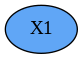

In [16]:
print('*******************************************************************')
print('                    Tree 1 ' )
Image(pydotplus.graphviz.graph_from_dot_data(getTree2plot(mejor_individuo.evoStats.bestSoFar.getTree(0))).create_png())

*******************************************************************
                    Tree 2 


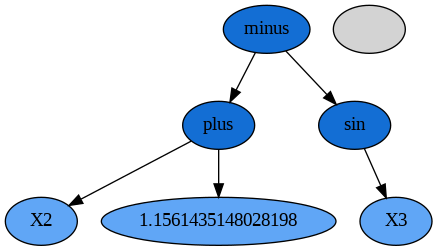

In [17]:
print('*******************************************************************')
print('                    Tree 2 ' )
Image(pydotplus.graphviz.graph_from_dot_data(getTree2plot(mejor_individuo.evoStats.bestSoFar.getTree(1))).create_png())

## Estimación de métricas de proyección

In [18]:
import metrics #Para ejecutar esta libreria compilar archivos.--> python setup.py build_ext --inplace
from scipy.spatial.distance import pdist, squareform

In [19]:
def mutualdistance(X,Y):
    '''
    X: Vectores en espacio original
    Y: Vectores en espacio proyectado'''
    MX = squareform(pdist(X))
    MY = squareform(pdist(Y))
    return MX, MY

In [36]:
evalTreeBestSoFar = mejor_individuo.getRawOutput(mejor_individuo.evoStats.bestSoFar, py2java(X['data'],True))
axis1 = java2py(evalTreeBestSoFar.getArray(0))
axis2 = java2py(evalTreeBestSoFar.getArray(1))
# np.c_[axis1, axis2]
# np.c_
trustworthiness(X['data'], np.c_[axis1,axis2], n_neighbors=5)
# MX, MY = mutualdistance(X['data'], np.c_[axis1,axis2])

np.float64(0.8576508838383838)

In [29]:
# MX.shape
# MY.shape

(800, 800)

In [25]:
from sklearn.manifold import trustworthiness
trustworthiness

In [24]:
K=
k=K
cont  = np.asarray([[k,metrics.cont_c(MX,MY,k)[0]] for k in range(1,K,2)])
# trust = np.asarray([[k,metrics.trust_c(MX,MY,k)[0]] for k in range(1,K,2)])
# qm    = np.asarray([[n,k,metrics.qm_c(MX,MY,n,k)[0]] for k in range(5,20,2) for n in range(2,k,2)])
# qm = np.asarray([[0.4*k, k,metrics.qm_c(MX,MY,0.4*k,k)[0]] for k in range(5,K,2)]) # n=0.4k

TypeError: 'float' object cannot be interpreted as an integer

In [23]:
cont

array([], dtype=float64)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

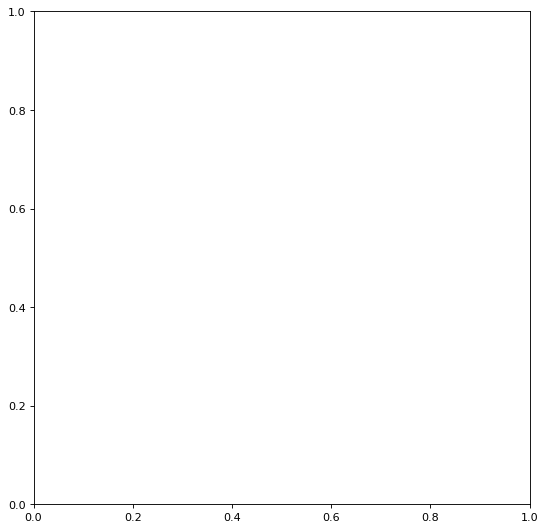

In [30]:
fig = plt.figure(figsize=(8, 8), dpi=80)

ax = fig.add_subplot(1,1,1)
ax.plot(cont[:,0],cont[:,1],'b', label='Continuity', linewidth=2, alpha=0.8)
ax.plot(trust[:,0],trust[:,1],'g', label='Trustworthines', linewidth=2, alpha=0.8)
ax.plot(qm[:,1],qm[:,2],'r', label='Topology preservation (qm)', linewidth=2, alpha=0.8)
ax.set_xlabel('k', fontsize=15)
ax.set_ylabel('Metric values', fontsize=15)
ax.legend()
ax.set_title(' Mapping quality',{'fontsize':20})


In [ ]:
## Finalizar máquina virtual de java
## Ejecute este comando sólo cuando termine la sesión. Al cerrar la máquina virtual, no es posible graficar árboles

# jpype.shutdownJVM()

## Borrador

In [ ]:
evalTreeBestSoFar = evo.getRawOutput(evo.evoStats.bestSoFar, py2java(X['data'],True))
axis1 = java2py(evalTrees.getArray(0))
axis2 = java2py(evalTrees.getArray(1))

fig = plt.figure(figsize=(12, 12), dpi=80)

ax = fig.add_subplot(2,2,1)
for i, cl in enumerate(np.unique(X['class'])):
    idx = np.where(X['class']==cl)[0]
    ax.scatter(axis1[idx], axis2[idx], c=args[i][0], marker=args[i][1], s=100, alpha=.7)
ax.set_xlabel('Tree 1', fontsize=15)
ax.set_ylabel('Tree 2', fontsize=15)
ax.set_title('Proyección GP',{'fontsize':20})

# Fitness vs Generacion
ax = fig.add_subplot(2,1,2)
ax.plot(np.arange(config.nGenerations), R['fitness'].max(axis=0), 'b', label='max', linewidth=2)
ax.plot(np.arange(config.nGenerations), R['fitness'].mean(axis=0), 'k', label='mean', linewidth=2)
ax.plot(np.arange(config.nGenerations), R['fitness'].min(axis=0), 'r', label='min', linewidth=2)
ax.set_xlabel('Generation',size=15)
ax.set_ylabel('Fitness',size=15)
ax.grid()
ax.legend(loc='lower right',fontsize=15)
ax.set_title('Fitness vs Generación',{'fontsize':20})

# Fitness promedio  vs nodos promedios por generación
ax = fig.add_subplot(2,2,2)
ax.scatter(R['fitness'].mean(axis=0), R['nodes'].sum(axis=2).mean(axis=0),
           c=args[1][0], marker=args[1][1], s=100, alpha=.7)
ax.set_ylabel('Nodos',size=15)
ax.set_xlabel('Fitness',size=15)
ax.grid()
ax.set_title('Fitness vs Nodos',{'fontsize':20})

plt.show()